# DIALOGUE - multi cellular programs

In [1]:
import pertpy as pt
import pandas as pd
import scanpy as sc


/Users/tessa/miniforge3/envs/pertpy-mf/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
/Users/tessa/miniforge3/envs/pertpy-mf/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

To use sccoda or tasccoda please install ete3 with pip install ete3

In [2]:
adata = pt.dt.dialogue_example()
adata

AnnData object with n_obs × n_vars = 5374 × 6329
    obs: 'nCount_RNA', 'nFeature_RNA', 'cellQ', 'gender', 'location', 'clinical.status', 'cell.subtypes', 'pathology', 'origin', 'subset'
    var: 'name'

In [3]:
# extract Patient ID from the index

adata.obs['sample'] = adata.obs.index.str.split('.').str[0] 

# convert pathology to categorical 
adata.obs['path_str'] = adata.obs.pathology.astype(str).astype("category")
category_mapping = {'True': 'pathological', 'False': 'Non-pathological'}
adata.obs['path_str']= adata.obs['path_str'].cat.rename_categories(category_mapping)


In [4]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

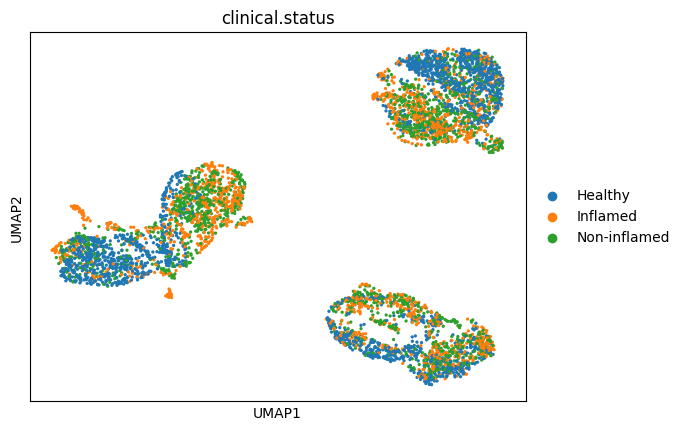

In [5]:
sc.pl.umap(
    adata,
    color=[
        "clinical.status"
    ],
)

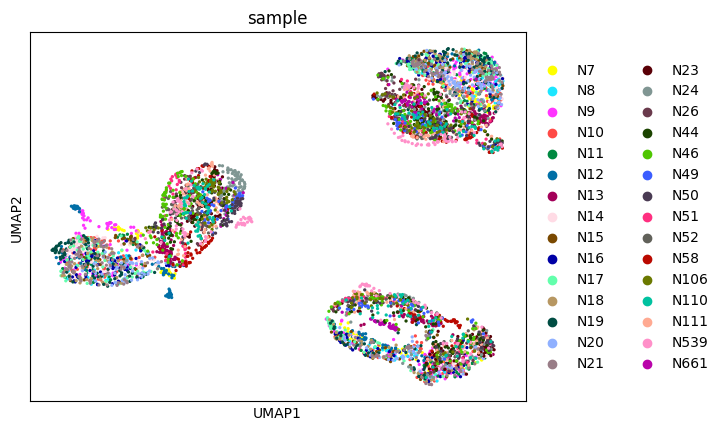

In [6]:
sc.pl.umap(
    adata,
    color=[
        "sample"
    ],
)

In [7]:
# ensure that every cell type is represented in every sample
isecs = pd.crosstab(adata.obs['cell.subtypes'], adata.obs['sample'])

isecs
(isecs >3).sum(axis=1)


cell.subtypes
CD8+ IELs      29
CD8+ IL17+      9
CD8+ LP        30
Macrophages    30
TA2            30
dtype: int64

In [8]:
# based on what we see above, remove CD8+ IL17+ because it's poorly represented across samples 
adata = adata[adata.obs['cell.subtypes'] != 'CD8+ IL17+']
isecs = pd.crosstab(adata.obs['cell.subtypes'], adata.obs['sample'])

# then remove the any sample which now has an unrepresented cell type
keep_pts = list(isecs.loc[:,(isecs > 3).sum(axis=0) == isecs.shape[0]].columns.values)
adata = adata[adata.obs['sample'].isin(keep_pts),:].copy()


In [9]:
adata

AnnData object with n_obs × n_vars = 5156 × 6329
    obs: 'nCount_RNA', 'nFeature_RNA', 'cellQ', 'gender', 'location', 'clinical.status', 'cell.subtypes', 'pathology', 'origin', 'subset', 'sample', 'path_str'
    var: 'name'
    uns: 'pca', 'neighbors', 'umap', 'clinical.status_colors', 'sample_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [10]:
dl = pt.tl.Dialogue(sample_id = "sample",
                   celltype_key = "cell.subtypes",
                   n_counts_key = "nCount_RNA",
                   n_mpcs = 3)

In [11]:
adata, mcps, ws, ct_subs = dl.calculate_multifactor_PMD(
    adata,
    normalize=True
)

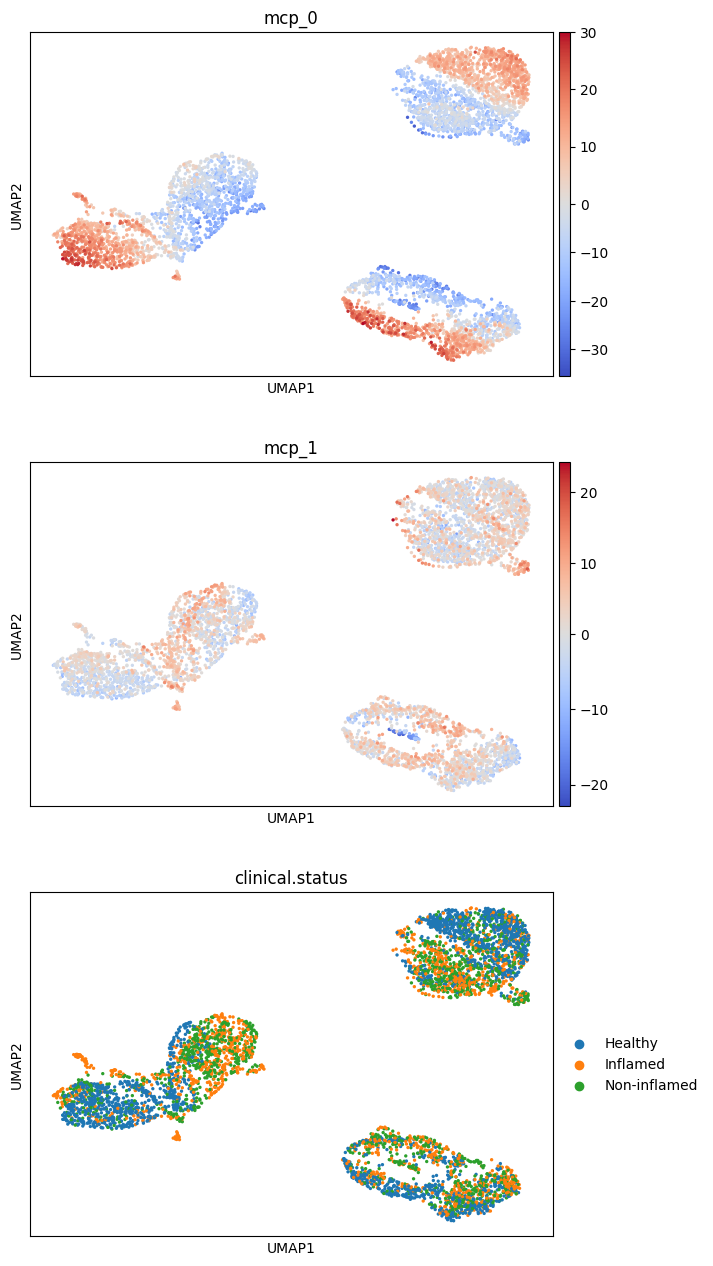

In [12]:
sc.pl.umap(adata, color=['mcp_0', 'mcp_1', 'clinical.status'], ncols=1, cmap='coolwarm', vcenter=0)

In [13]:
# test which MCPs are associated with pathology status
# 
dl.test_association(adata, "path_str")


{'pvals':                 mcp_0     mcp_1     mcp_2
 CD8+ IELs    0.002495  0.760186  0.026097
 CD8+ LP      0.003275  0.335389  0.013104
 Macrophages  0.011599  0.267990  0.019691
 TA2          0.000298  0.485668  0.000004,
 'tstats':                 mcp_0     mcp_1     mcp_2
 CD8+ IELs    3.334117 -0.308345 -2.354108
 CD8+ LP      3.226379 -0.980819 -2.656113
 Macrophages  2.708076  1.131028 -2.479509
 TA2          4.149622 -0.706928 -5.761043,
 'pvals_adj':                 mcp_0     mcp_1     mcp_2
 CD8+ IELs    0.004367  0.760186  0.026097
 CD8+ LP      0.004367  0.647557  0.026097
 Macrophages  0.011599  0.647557  0.026097
 TA2          0.001190  0.647557  0.000016}

<Axes: xlabel='cell.subtypes', ylabel='mcp_0'>

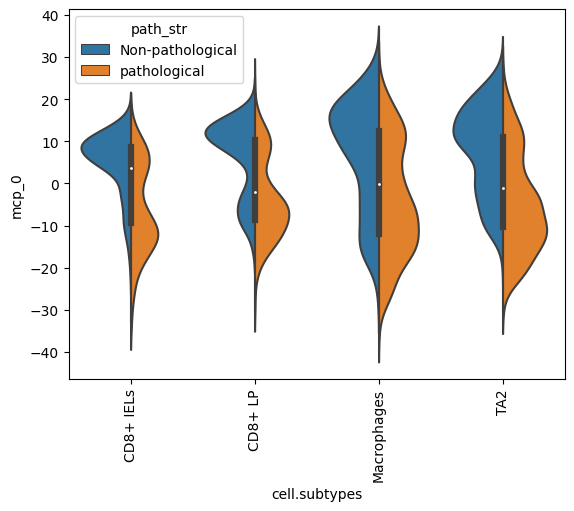

In [14]:
# mcp_0 looks significantly associated with pathology status
# let's plot its values for individual cells of different source pathologies

pt.pl.dg.split_violins(adata, split_key="path_str",celltype_key="cell.subtypes", mcp="mcp_0")

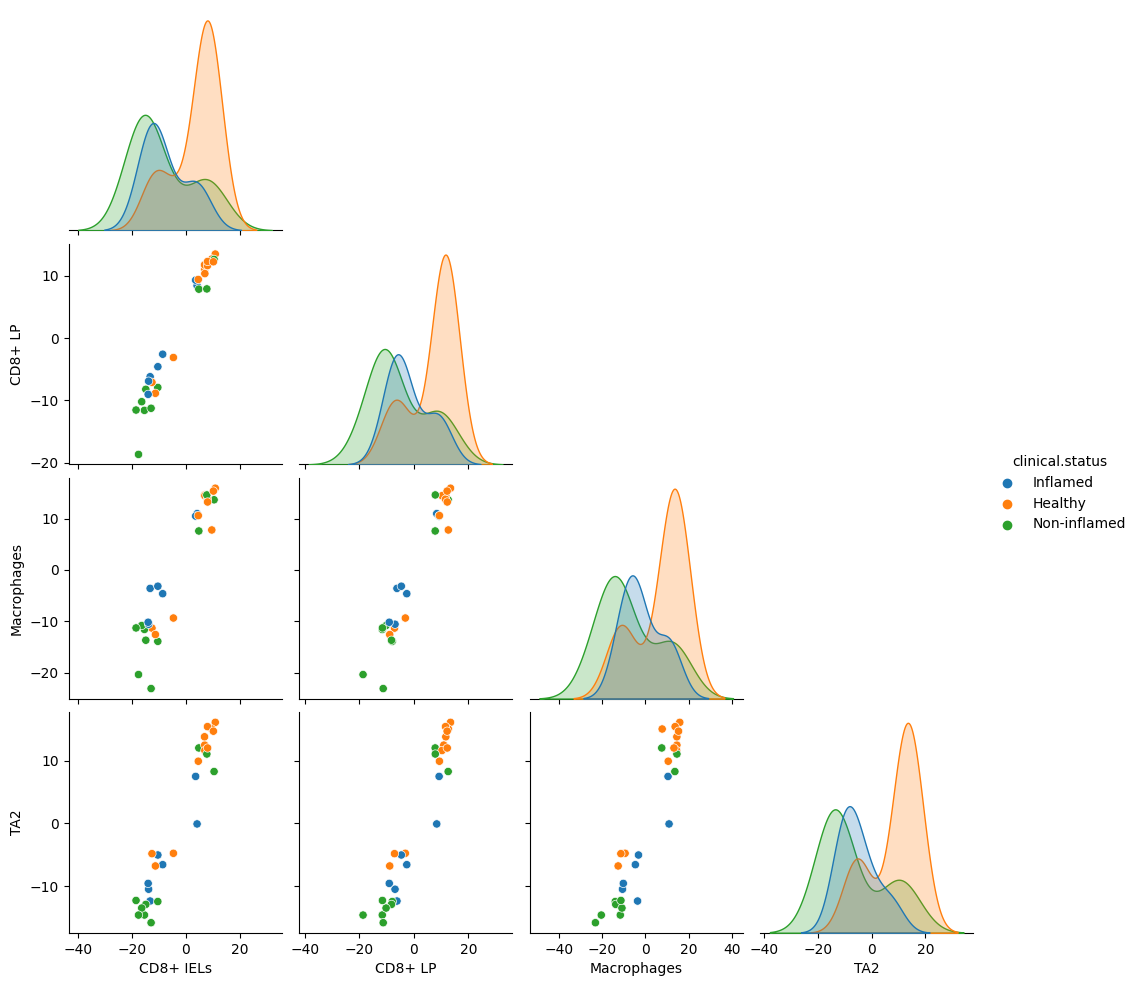

In [15]:

pt.pl.dg.pairplot(adata, celltype_key="cell.subtypes", color="clinical.status", mcp="mcp_0", sample_id="sample")

In [16]:
extrema_genes = dl.get_extrema_MCP_genes(ct_subs)

In [17]:
# the top 10% of CD8+ IELs mcp_0 scores compared to the bottom 10% 
extrema_genes['mcp_0']['TA2'].head(10)

,names,scores,logfoldchanges,pvals,pvals_adj
0,LGALS4,30.725128,3.706235,5.814764e-96,3.680164e-92
1,FABP1,27.608805,10.455679,1.147060e-77,1.451949e-74
2,CA2,22.598703,7.000807,1.233979e-66,1.301643e-63
3,COX4I1,21.681202,1.968014,7.606420e-61,6.017629e-58
4,ADIRF,21.092482,6.183791,1.339211e-63,1.210838e-60
5,SELENBP1,20.836832,5.738823,1.674979e-57,1.060094e-54
6,HMGCS2,20.143518,6.274435,7.779422e-59,5.470662e-56
7,LGALS3,19.963385,3.821214,2.782692e-52,1.354743e-49
8,URAD,19.835522,6.441755,2.841218e-56,1.498506e-53
9,PHGR1,18.831448,3.467256,1.124717e-51,5.084525e-49


In [18]:
# Note: this is slow! It takes 1 hour to run on a laptop with 16 GB RAM
all_results, new_mcps = dl.multilevel_modeling(ct_subs=ct_subs,
                                     mcp_scores=mcps,
                                     ws_dict=ws,
                                     confounder="gender",
                                   )

Output()

3 MCPs identified for CD8+ IELs and CD8+ LP.

3 MCPs identified for CD8+ IELs and Macrophages.

3 MCPs identified for CD8+ IELs and TA2.

3 MCPs identified for CD8+ LP and Macrophages.

3 MCPs identified for CD8+ LP and TA2.

3 MCPs identified for Macrophages and TA2.

In [22]:
ta2_genes = dl.get_mlm_mcp_genes(celltype = "TA2", results = all_results, MCP = "mcp_0")

In [56]:
# extract significantly different genes from the extrema calculation
sig_genes = extrema_genes['mcp_0']['TA2'][extrema_genes['mcp_0']['TA2']['pvals_adj'] < 0.05]
up_genes_extrema = sig_genes[sig_genes['logfoldchanges'] > 0 ]['names']
down_genes_extrema = sig_genes[sig_genes['logfoldchanges'] < 0 ]['names']
# all of the Dialogue genes from the multilevel model are also in this list
len(set(ta2_genes['up_genes']).intersection(set(up_genes_extrema)))

101

In [60]:
up_genes_extrema = sig_genes[sig_genes['logfoldchanges'] > 0 ]['names']
# some of the decreased genes are not shared
print(set(ta2_genes['down_genes']).intersection(set(down_genes_extrema)))

# print the Dialogue genes not in the extrema list
set(ta2_genes['down_genes']).difference(set(down_genes_extrema))

{'RPL39', 'RPS29', 'TSPAN8', 'RPS27', 'RPS17L', 'MTRNR2L3', 'USMG5'}


{'CALM2', 'STAG2'}